In [ ]:
#Pkg.rm("TensorOperations")
#Pkg.free("git://github.com/Jutho/TensorOperations.jl.git")
versioninfo()

In [1]:
1+1

2

In [2]:
Pkg.update()
Pkg.add("TensorOperations")
#Pkg.add("PyPlot")
using TensorOperations
TO = TensorOperations

INFO: Updating METADATA...
INFO: Computing changes...
INFO: No packages to install, update or remove
INFO: Nothing to be done
INFO: METADATA might be out-of-date — you may not have the latest version of TensorOperations
INFO: Use `Pkg.update()` to get the latest versions of your packages


LoadError: LoadError: LoadError: LoadError: MethodError: `start` has no method matching start(::Type{Symbol})
while loading /home/julian/.julia/v0.4/Cartesian/src/Cartesian.jl, in expression starting on line 142
while loading /home/julian/.julia/v0.4/TensorOperations/src/TensorOperations.jl, in expression starting on line 28
while loading In[2], in expression starting on line 4

  likely near /home/julian/.julia/v0.4/TensorOperations/src/TensorOperations.jl:11
  likely near /home/julian/.julia/v0.4/TensorOperations/src/TensorOperations.jl:11


In [48]:

#Pkg.add("IndexNotation")

type SimpleRnn
    
    sigma::Function
    sigma_prime::Function

    C::Array
    Ws::Array
    Wx::Array
    b::Array

    grad_C::Array
    grad_Ws::Array
    grad_Wx::Array
    grad_b::Array
    
    s::Array
    dt::Real
    
    timesteps::Int
    
    function SimpleRnn(size_x,size_s,dt = 1e-2)
        C = randn((size_x,size_s))
        sigma(z) = tanh(z)#sign(z).*abs(z).^0.5 #tanh(z)
        sigma_prime(z) = sech(z).^2#0.5*sign(z).*abs(z).^(-0.5)#sech(z).^2
        
        Wx = randn((size_s,size_x))
        Ws = randn((size_s,size_s))
        
        grad_C = zeros((size_s,size_x,size_s))
        grad_Ws = zeros((size_s,size_s,size_s))
        grad_Wx = zeros((size_s,size_s,size_x))
        grad_b = zeros((size_s,size_s,1))
        b = zeros((size_s,1))
        s = zeros((size_s,1))
        timesteps = 0
        rnn = new(sigma,sigma_prime,C,Ws,Wx,b,grad_C,grad_Ws,grad_Wx,grad_b,s,dt,timesteps)
        return rnn
    end
end

function print(rnn::SimpleRnn)
    println("rnn:")
    println("C: $(rnn.C)")
    println("Ws: $(rnn.Ws)")
    println("Ws: $(rnn.Wx)")
    println("b: $(rnn.b)")
    println("s: $(rnn.s)")
    println()
end

print (generic function with 1 method)

In [29]:

using PyPlot

function mod_to_length(i,len)
    i = i % len
    if i == 0 i = len end
    i
end

function forward(rnn::SimpleRnn,x)
    z = rnn.Wx*x + rnn.Ws*rnn.s + rnn.b
    ds = rnn.sigma(z)
    x_next = rnn.C*rnn.s
    rnn.s += rnn.dt*ds
    return x_next
end

function set_state(rnn::SimpleRnn)
    rnn.s *= 0
    rnn.grad_Ws *= 0
    rnn.grad_b *= 0
    rnn.grad_Wx *= 0
    rnn.grad_C *= 0
end

gamma = 0.0
function forward_online(rnn::SimpleRnn,x,x_next_true,verbose=false)
    #timestep

    
    
    z = rnn.Wx*x + rnn.Ws*rnn.s + rnn.b
    
    x_next_pred = rnn.C*rnn.s
    delta = (x_next_pred - x_next_true)

    #compute learning update signals
    dWs = reshape(contract_2_3_idx_last_first(delta'*rnn.C,rnn.grad_Ws),size(rnn.Ws)) #TO.tensorcontract(delta'*C,["a","k"] ,grad_W_s,["k","i","j"])
    dWx = reshape(contract_2_3_idx_last_first(delta'*rnn.C,rnn.grad_Wx),size(rnn.Wx))
    db = reshape(contract_2_3_idx_last_first(delta'*rnn.C,rnn.grad_b),size(rnn.b))
    dC = get_dC(rnn,delta) + reshape(contract_2_3_idx_last_first(delta'*rnn.C,rnn.grad_C),size(rnn.C))

    
    #compute temporal update signals
    d_grad_Ws = get_d_grad_Ws(rnn,z) - gamma*rnn.grad_Ws
    d_grad_b = get_d_grad_b(rnn,z) - gamma*rnn.grad_b
    d_grad_Wx = get_d_grad_Wx(rnn,z,x) - gamma*rnn.grad_Wx
    d_grad_C = get_d_grad_C(rnn,z) - gamma*rnn.grad_C
    
    ds = rnn.sigma(z) - gamma*rnn.s
    

    #update temporal dynamics
    rnn.grad_b += rnn.dt*d_grad_b
    rnn.grad_Wx += rnn.dt*d_grad_Wx
    rnn.grad_Ws += rnn.dt*d_grad_Ws
    rnn.grad_C += rnn.dt*d_grad_C

    rnn.s += rnn.dt*ds
    
    #update weights
    learning_rate = 0.01#0.01*(0.998)^rnn.timesteps#min(0.07,norm(delta))
    clip_gradients = true
    lo = -Inf
    hi = Inf
    
    if clip_gradients
        lo = -5
        hi = 5
    end

    dtc = dtw = dtb = learning_rate*rnn.dt
    
    if rand() < 1.1
        rnn.Ws -= dtw*clamp(dWs,lo,hi)
        rnn.Wx -= dtw*clamp(dWx,lo,hi)
        rnn.C -= dtc*clamp(dC,lo,hi)
        rnn.b -= dtb*clamp(db,lo,hi)
        #println(mean(abs(dWs)), " ", mean(abs(dWx)), " ", mean(abs(dC)), " ", mean(abs(db)))
    end
        
    if verbose
        println(rnn)
        println()
    end
        
    rnn.timesteps += 1
    return x_next_pred
    #TODO
    #fix 3d array arithmetic
    #gradient checks
end

function forward_predict(rnn::SimpleRnn,x)    
    z = rnn.Wx*x + rnn.Ws*rnn.s + rnn.b
    x_next_pred = rnn.C*rnn.s

    ds = rnn.sigma(z) - gamma*rnn.s
    rnn.s += rnn.dt*ds    
    return x_next_pred
end

function get_dWx(rnn::SimpleRnn,delta,x,z)
    size_ = size(rnn.Wx)
    dWx = similar(rnn.Wx)
    for i = 1:size_[1]
        for j = 1:size_[2]
            dWx[i,j] = dot(delta'[:],rnn.C[:,i]).*rnn.sigma_prime(z[i])*x[j]
        end
    end
    dWx
end

function get_dC(rnn::SimpleRnn,delta)
    size_ = size(rnn.C)
    dC = similar(rnn.C)
    for i = 1:size_[1]
        for j = 1:size_[2]
            dC[i,j] = delta[i]*rnn.s[j]
        end
    end
    dC
end

function get_d_grad_C(rnn::SimpleRnn,z)
    size_ = size(rnn.grad_C)
    d_grad_C = similar(rnn.grad_C)
    second_term =  contract_2_3_idx_last_first(rnn.Ws,rnn.grad_C)
    for k = 1:size_[1]
        for i = 1:size_[2]
            for j = 1:size_[3]
                d_grad_C[k,i,j] = rnn.sigma_prime(z[k]) 
                *(second_term[k,i,j])
#                 TO.tensorcontract(rnn.grad_Ws,["i","j","l"], rnn.Ws,["k","l"]))                
            end
        end
    end
    return d_grad_C
end




function get_d_grad_Ws(rnn::SimpleRnn,z)
    size_ = size(rnn.grad_Ws)
    d_grad_Ws = similar(rnn.grad_Ws)
    second_term =  contract_2_3_idx_last_first(rnn.Ws,rnn.grad_Ws)
    for k = 1:size_[1]
        for i = 1:size_[2]
            for j = 1:size_[3]
                d_grad_Ws[k,i,j] = rnn.sigma_prime(z[k]) 
                *(kronecker_delta(i,k)*rnn.s[j] +second_term[k,i,j])
#                 TO.tensorcontract(rnn.grad_Ws,["i","j","l"], rnn.Ws,["k","l"]))                
            end
        end
    end
    return d_grad_Ws
end

function get_d_grad_Wx(rnn::SimpleRnn,z,x)
    size_ = size(rnn.grad_Wx)
    d_grad_Wx = similar(rnn.grad_Wx)
    second_term =  contract_2_3_idx_last_first(rnn.Ws,rnn.grad_Wx)
    for k = 1:size_[1]
        for i = 1:size_[2]
            for j = 1:size_[3]
                d_grad_Wx[k,i,j] = rnn.sigma_prime(z[k]) 
                *(kronecker_delta(i,k)*x[j] +second_term[k,i,j])
#                 TO.tensorcontract(rnn.grad_Ws,["i","j","l"], rnn.Ws,["k","l"]))                
            end
        end
    end
    return d_grad_Wx
end

function get_d_grad_b(rnn::SimpleRnn,z)
    size_ = size(rnn.grad_b)
    d_grad_b = similar(rnn.grad_b)
    second_term =  contract_2_3_idx_last_first(rnn.Ws,rnn.grad_b)
    for k = 1:size_[1]
        for i = 1:size_[2]
            for j = 1:size_[3]
                d_grad_b[k,i,j] = rnn.sigma_prime(z[k]) 
                *(kronecker_delta(i,k) +second_term[k,i,j])
#                 TO.tensorcontract(rnn.grad_Ws,["i","j","l"], rnn.Ws,["k","l"]))                
            end
        end
    end
    return d_grad_b
end

function contract_2_3_idx_last_first(a::Array,b::Array)
    @assert (length(size(a)) == 2 && length(size(b)) == 3)
    c = Array(eltype(a),(size(a)[1],size(b)[2],size(b)[3]))
    for i = 1:size(a)[1]
        for j = 1:size(b)[2]
            for k = 1:size(b)[3]
                tmp = 0
                for l = 1:size(b)[1]
                    tmp += a[i,l]*b[l,j,k]
                end
                c[i,j,k] = tmp
            end
        end
    end
    return c
end

function contract_3_2_idx_last_last(a::Array,b::Array)
    @assert (length(size(a)) == 3 && length(size(b)) == 2)
    c = Array(eltype(a),(size(a)[1],size(a)[2],size(b)[1]))
    for i = 1:size(a)[1]
        for j = 1:size(a)[2]
            for k = 1:size(b)[1]
                tmp = 0
                for l = 1:size(b)[2]
                    tmp += a[i,j,l]*b[k,l]
                end
                c[i,j,k] = tmp
            end
        end
    end
    return c
end

function kronecker_delta(i::Int,j::Int)
    return i == j ? 1 : 0
end


kronecker_delta (generic function with 1 method)

In [ ]:
print(rnn)

In [5]:
#rnn = SimpleRnn(2,4)
function step_forward(rnn::SimpleRnn,x_0,n_steps;tracking=false)
    if tracking
        outs = []
        push!(outs,x_0)
    end
    for i = 1:n_steps
        x_0 = forward(rnn,x_0)
        if tracking push!(outs,x_0) end
    end
    if tracking return outs else return x_0 end
end

function concat_list_of_arrays(array_list)
    return reduce((x,y) -> cat(2,x,y),array_list)'
end




function step_forward_online(rnn::SimpleRnn,x_0,n_steps,tracking=false)

end

step_forward_online (generic function with 2 methods)

In [49]:
rnn = SimpleRnn(1,2,0.01)
x = sin(collect(0:0.01:30))
outs = []
real_outs = []
training_length = 4*length(x)
instances = 1
for i = 1:instances*training_length
    if i % (training_length) == 1
        set_state(rnn)
    end
    i % 2000 == 2000 ? verbose = true : verbose = false
    cur,next = mod_to_length(i,length(x)),mod_to_length(i+1,length(x))
    push!(outs,forward_online(rnn,[x[cur]],[x[next]],verbose))
    push!(real_outs,x[next])
end

for i = instances*training_length+1:instances*training_length+length(x)
    if i % (training_length) == 1
        set_state(rnn)
    end
    cur,next = mod_to_length(i,length(x)),mod_to_length(i+1,length(x))
    push!(outs,forward_predict(rnn,outs[end]))
    push!(real_outs,x[next])
    
end



#forward(rnn,[1,2])
# outs = reduce((x,y) -> cat(2,x,y),outs)
# x = outs[1,:]
# y = outs[2,:]
# scatter(x,y)
#outs

In [ ]:
for i = training_length+1:training_length+1000
    cur,next = mod_to_length(i,length(x)),mod_to_length(i+1,length(x))
    push!(outs,forward_predict(rnn,outs[end]))
    push!(real_outs,x[next])
    
end

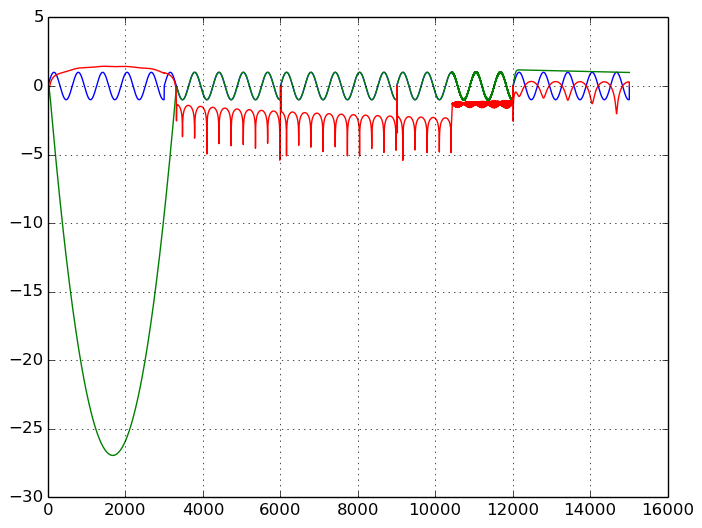

SimpleRnn(sigma,sigma_prime,1x2 Array{Float64,2}:
 -1.02676  -1.02016,2x2 Array{Float64,2}:
 -0.0532761  -2.90473  
 -3.50022    -0.0536027,2x1 Array{Float64,2}:
 -0.0360733
 -1.91193  ,2x1 Array{Float64,2}:
 -1.57279
 -1.57279,2x1x2 Array{Float64,3}:
[:, :, 1] =
 0.0
 0.0

[:, :, 2] =
 0.0
 0.0,2x2x2 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0

[:, :, 2] =
 0.0  0.0
 0.0  0.0,2x2x1 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0,2x2x1 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0,2x1 Array{Float64,2}:
  28.7947
 -29.949 ,0.01,12004)

In [50]:
#semilogy((outs-real_outs))
outs_plot = concat_list_of_arrays(outs)
real_outs_plot = concat_list_of_arrays(real_outs)

plot_end =instances*training_length+length(x)
#plot_begin = instances*training_length-5*length(x)
plot_begin = 1#

plot(real_outs_plot[plot_begin:plot_end])
plot(outs_plot[plot_begin:plot_end])
plot(log10(abs(real_outs_plot-outs_plot))[plot_begin:plot_end])
grid()
rnn

In [ ]:
print(rnn)

## TODO:
s seems to reach a steady state, and C does all the learning. How do we avoid s reaching some unstable steady state?

In [ ]:
rnn = SimpleRnn(2,10,0.05)
outs = step_forward(rnn,[1,1],1000,tracking=true)
#forward(rnn,[1,2])
outs = reduce((x,y) -> cat(2,x,y),outs)
x = outs[1,:]
y = outs[2,:]
scatter(x,y)

In [ ]:
tensoradd([1,2],[1,2])

In [ ]:
using PyPlot
x = collect(-1:0.01:1)

plot(x,sech(x).^2)
plot(x,rnn.sigma(x))

In [ ]:
[1,2]'*randn(2,2)